# Map of the location of the SR1b section transect and the DIMES moorings

In [ ]:
import numpy as np
import xarray as xr
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
# Mooring data
moorings = loadmat('data/DIMES_moorings/moorings_5levs_unfiltered_corrected.mat')
mooring_lat = moorings['c']['lat'][0][0][0][0]  # Latitude of the mooring in the Southern Ocean
mooring_lon = moorings['c']['lon'][0][0][0][0]  # Longitude of the mooring in the Southern Ocean
mooring_coordinates = [
    (moorings['c']['lat'][0][0][0][0] , moorings['c']['lon'][0][0][0][0]),
    (moorings['sw']['lat'][0][0][0][0] , moorings['sw']['lon'][0][0][0][0]),
    (moorings['se']['lat'][0][0][0][0] , moorings['se']['lon'][0][0][0][0]),
    (moorings['nw']['lat'][0][0][0][0] , moorings['nw']['lon'][0][0][0][0]),
    (moorings['ne']['lat'][0][0][0][0] , moorings['ne']['lon'][0][0][0][0]),
]
moorings_labels = ["C", "SW", "SE", "NW", "NE"]

# Section data
data = loadmat('data/SR1b_section/sr1b_all.mat')
icyc = np.where(data['buf_year'] != 1999)[1] # exclude 1999 # TODO: why?
buf_lat = data['buf_lat'][0,icyc]
buf_lon = data['buf_lon'][0,icyc]
buf_year = data['buf_year'][:,icyc].reshape(316)

# sample points along section
start_lon_vals = []
end_lon_vals = []
start_lat_vals = []
end_lat_vals = []
for yr in np.unique(buf_year):
  idx_yr = np.where(buf_year == yr)[0]
  start_lon_vals.append(np.min(buf_lon[idx_yr]))
  end_lon_vals.append(np.max(buf_lon[idx_yr]))
  start_lat_vals.append(np.max(buf_lat[idx_yr]))
  end_lat_vals.append(np.min(buf_lat[idx_yr]))
start_lon = np.mean(np.array(start_lon_vals))
end_lon = np.mean(np.array(end_lon_vals))
start_lat = np.mean(np.array(start_lat_vals))
end_lat = np.mean(np.array(end_lat_vals))

# Extract unique points along the section
nr_points = 30
lon_along_section = np.linspace(start_lon, end_lon, nr_points)
lat_along_section = np.linspace(start_lat, end_lat, nr_points)

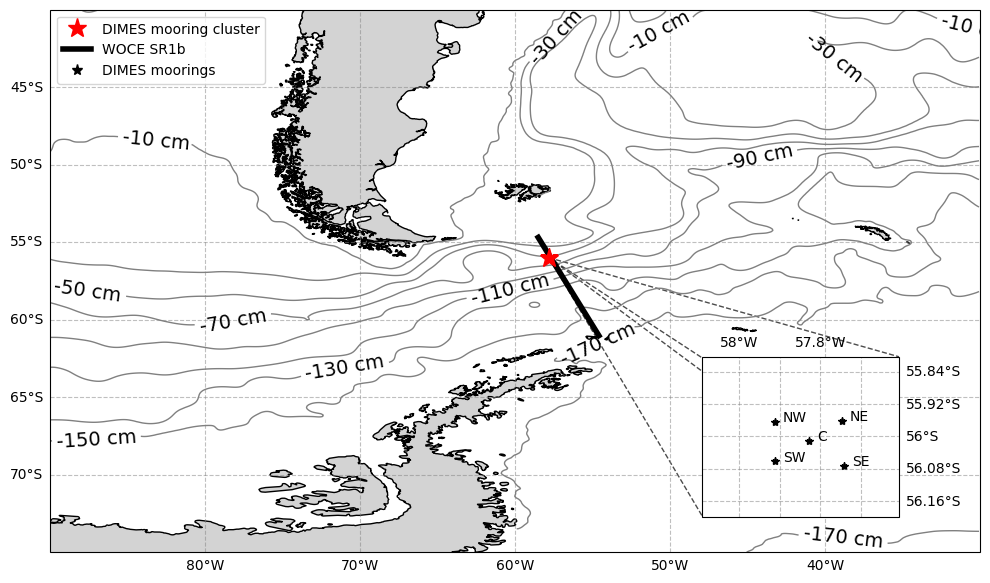

In [5]:
#%% plot of moorings and section SR1b
 
# Load dataset
ds = xr.open_dataset('data/CMEMS_reanalysis/cmems_mod_glo_phy_my_0.083deg_P1M-m_1993-2020_zos.nc')
ssh_mean = ds['zos'].mean(dim='time')
 
# Convert contour levels to centimeters
contour_levels = np.arange(ssh_mean.min() * 100, ssh_mean.max() * 100, 20)
 
# Create a figure with a specified projection (e.g., PlateCarree)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m', linewidth=1, color='black')
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Contours for SSH with geoid as reference level
contour = ax.contour(ssh_mean.longitude, ssh_mean.latitude, ssh_mean * 100, levels=contour_levels, colors='gray', linewidths=1, linestyles='solid')
ax.clabel(contour, inline=True, fontsize=14, colors='k', fmt='%1.0f cm')

ax.set_extent([-90, -30, -75, -40], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
 
# Plot the C mooring location and hydrographic section
ax.plot(mooring_lon, mooring_lat, 'r*', markersize=14, label='DIMES mooring cluster', zorder=10)
ax.plot(lon_along_section,lat_along_section,'k-', linewidth=4, label='WOCE SR1b')

# Inset with all 5 mooring locations
circ_ax = fig.add_axes([0.65, 0.2, 0.2, 0.2], projection=ccrs.PlateCarree(), zorder=15)
circ_ax.coastlines(resolution='10m', linewidth=1, color='black')
for (lat, lon), label in zip(mooring_coordinates, moorings_labels):
    circ_ax.plot(lon, lat, 'k*', markersize=6)
    circ_ax.text(lon + 0.02, lat, label, fontsize=10)
circ_ax.set_extent([mooring_lon - 0.25 - 1/72, mooring_lon + 0.25 - 1/36, mooring_lat - 0.25 + 1/16, mooring_lat + 0.25 - 1/24], crs=ccrs.PlateCarree())
gl = circ_ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', color='gray', alpha=0.5)
# Set gridline spacing for latitude and longitude (in degrees)
gl.xlocator = plt.FixedLocator(np.arange(mooring_lon - 0.25 - 1/72, mooring_lon + 0.25 - 1/36, 0.1))  # Adjust the values as needed
gl.ylocator = plt.FixedLocator(np.arange(mooring_lat - 0.25 + 1/16, mooring_lat + 0.25 - 1/24, 0.1))  # Adjust the values as needed
gl.top_labels = True
gl.right_labels = True
gl.bottom_labels = False
gl.left_labels = False
gl.xlocator = plt.MaxNLocator(nbins=6)
gl.ylocator = plt.MaxNLocator(nbins=6)

# Coordinates for the corners of inset
corner_coordinates = [
    (-47.9, -72.75),
    (-47.9, -62.5),
    (-35.25, -62.4),
    (-35.25, -72.75)
]
for corner in corner_coordinates:
    ax.plot([mooring_lon, corner[0]], [mooring_lat, corner[1]], linestyle = '--', color='k', alpha=0.7, linewidth=1, zorder=0)

# Create a custom legend entry with a black star marker
custom_legend_entry = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=8, label='Black Star')
handles, labels = ax.get_legend_handles_labels()
# Add custom legend entry
handles.append(custom_legend_entry)
labels.append('DIMES moorings')
ax.legend(handles=handles, labels=labels, loc='upper left')# bbox_to_anchor=(0.2, 0.995))

plt.savefig('figures_paper/map_moorings_section.pdf', bbox_inches="tight")
plt.show()